In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

EDA and preprocessing has been experimented in other notebook so this is clean straight forward implementation


In [5]:
data = pd.read_csv('credit-card-transactions-dataset/credit_card_transactions.csv')
outliers_threshold = 2300
outliers = data[data['amt'] > outliers_threshold]
data = data[data['amt'] <= outliers_threshold]
drop_columns = ['Unnamed: 0','first','last','trans_num','unix_time','merch_zipcode','state','street','zip']
data = data.drop(columns=drop_columns)

In [6]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['trans_year'] = data['trans_date_trans_time'].dt.year
data['trans_month'] = data['trans_date_trans_time'].dt.month
data['trans_day'] = data['trans_date_trans_time'].dt.day
data['trans_hour'] = data['trans_date_trans_time'].dt.hour

# time of the day morning , afternoon , evening , night into one hot encoded label
conditions = [
    ((data['trans_hour'] >= 6) & (data['trans_hour'] < 12)),
    ((data['trans_hour'] >= 12) & (data['trans_hour'] < 18)),
    ((data['trans_hour'] >= 18) & (data['trans_hour'] < 24)),
    ((data['trans_hour'] >= 0) & (data['trans_hour'] < 6))
]
choices = ['morning', 'afternoon', 'evening', 'night']
data['time_of_day'] = np.select(conditions, choices, default='Unknown')
data =  pd.get_dummies(data, columns=['time_of_day'])
bool_columns = data.select_dtypes(include=['bool']).columns
data[bool_columns] = data[bool_columns].astype(int)
data = data.drop(columns=['trans_date_trans_time','trans_hour'])


In [7]:
data.head(5)    

,cc_num,merchant,category,amt,gender,city,lat,long,city_pop,job,...,merch_lat,merch_long,is_fraud,trans_year,trans_month,trans_day,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,36.0788,-81.1781,3495,"Psychologist, counselling",...,36.011293,-82.048315,0,2019,1,1,0,0,0,1
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,48.8878,-118.2105,149,Special educational needs teacher,...,49.159047,-118.186462,0,2019,1,1,0,0,0,1
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,42.1808,-112.2620,4154,Nature conservation officer,...,43.150704,-112.154481,0,2019,1,1,0,0,0,1
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,46.2306,-112.1138,1939,Patent attorney,...,47.034331,-112.561071,0,2019,1,1,0,0,0,1
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,38.4207,-79.4629,99,Dance movement psychotherapist,...,38.674999,-78.632459,0,2019,1,1,0,0,0,1


In [8]:
data['dob'] = pd.to_datetime(data['dob'])
data['birth_year'] = data['dob'].dt.year
data['owner_age'] = data['trans_year'] - data['birth_year']
data = data.drop(columns=['dob', 'birth_year','trans_year'])

In [9]:
from geopy.distance import geodesic
def calculate_distance(row):
    customer_coords = (row['lat'], row['long'])
    merchant_coords = (row['merch_lat'], row['merch_long'])
    return geodesic(customer_coords, merchant_coords).kilometers

data['distance_km'] = data.apply(calculate_distance, axis=1)


data = data.drop(columns=['lat', 'long', 'merch_lat', 'merch_long'])

In [10]:
bins = [0, 18, 35, 50, 65 , 100]
labels = [0, 1, 2, 3, 4]  # 0: <18, 1: 18-34, 2: 35-49, 3: 50 , 4: 65+
data['age_group'] = pd.cut(data['owner_age'], bins=bins, labels=labels, right=False)
data = data.drop(columns='owner_age')

from sklearn.preprocessing import LabelEncoder
def encode_category(data,column):
    le = LabelEncoder()
    for col in column:
        data[col] = le.fit_transform(data[col])
    return data

categories = ['merchant', 'cc_num', 'category','gender','job','city','age_group']

data = encode_category(data,categories)


data.head()

,cc_num,merchant,category,amt,gender,city,city_pop,job,is_fraud,trans_month,trans_day,time_of_day_afternoon,time_of_day_evening,time_of_day_morning,time_of_day_night,distance_km,age_group
0,444,514,8,4.97,0,526,3495,370,0,1,1,0,0,0,1,78.773821,1
1,42,241,4,107.23,0,612,149,428,0,1,1,0,0,0,1,30.216618,2
2,237,390,0,220.11,1,468,4154,307,0,1,1,0,0,0,1,108.102912,3
3,509,360,2,45.00,1,84,1939,328,0,1,1,0,0,0,1,95.685115,3
4,368,297,9,41.96,1,216,99,116,0,1,1,0,0,0,1,77.702395,1


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296110 entries, 0 to 1296674
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   cc_num                 1296110 non-null  int64  
 1   merchant               1296110 non-null  int64  
 2   category               1296110 non-null  int64  
 3   amt                    1296110 non-null  float64
 4   gender                 1296110 non-null  int64  
 5   city                   1296110 non-null  int64  
 6   city_pop               1296110 non-null  int64  
 7   job                    1296110 non-null  int64  
 8   is_fraud               1296110 non-null  int64  
 9   trans_month            1296110 non-null  int32  
 10  trans_day              1296110 non-null  int32  
 11  time_of_day_afternoon  1296110 non-null  int64  
 12  time_of_day_evening    1296110 non-null  int64  
 13  time_of_day_morning    1296110 non-null  int64  
 14  time_of_day_night      

In [13]:
finalized_preprocessed_data = data.copy()
finalized_preprocessed_data.to_csv('finalized_preprocessed_data.csv', index=False)

In [14]:
# use smote to balance the data
from imblearn.over_sampling import SMOTE

X = data.drop(columns='is_fraud')
y = data['is_fraud']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [15]:
#implement mlflow here
import mlflow
import mlflow.lightgbm

client = mlflow.tracking.MlflowClient()
mlflow.set_tracking_uri("http://127.0.0.1:8080")
experiment_description = "LightGBM model for credit card fraud detection with hyperparameter tuning and SMOTE"
experiment_tags = {
    "project": "Credit Card Fraud Detection",   
    "model": "LightGBM",
    "technique": "SMOTE",
    "hyperparameter_tuning": "GridSearchCV"
}





In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score , recall_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgbm
from lightgbm  import early_stopping, log_evaluation
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)





# do hyper parameter search for lightgbm

param_grid = {
    
    'num_leaves': [25,  50 ],
    'learning_rate': [ 0.05, 0.1],
    'n_estimators': [200, 500, 1000],
    'max_depth': [3, 5, 10, 20 ,-1],
}




lgbm_model = lgbm.LGBMClassifier()
random_search = RandomizedSearchCV(estimator=lgbm_model, param_distributions=param_grid,n_iter=10, cv=3,scoring='f1', n_jobs=-1, verbose=2 , random_state=42)
# Yes, using X_test and y_test as eval_set during hyperparameter tuning exposes the test data,
# which can lead to data leakage and overly optimistic performance estimates.
# Instead, use a validation split from the training data.


# Split X_train further into training and validation sets
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

random_search.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    eval_metric="f1",
    callbacks=[early_stopping(stopping_rounds=50), log_evaluation(0)]
)
y_pred = random_search.predict(X_test)
import joblib

joblib.dump(random_search.best_estimator_, "lgbm_model.pkl")


f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)


metric = {
    "f1_score": f1,
    "precision": precision,
    "recall": recall}





Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 549658, number of negative: 549950
[LightGBM] [Info] Number of positive: 549658, number of negative: 549950
[LightGBM] [Info] Number of positive: 549658, number of negative: 549950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.148628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1099608, number of used features: 16
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1850
[LightGBM] [Info] Number of data points in the train set: 1099608, number of used features: 16
[LightGBM]

In [17]:
experiment_description = "LightGBM model for credit card fraud detection with hyperparameter tuning and SMOTE"
experiment_tags = {
    "project": "Credit Card Fraud Detection",   
    "model": "LightGBM",
    "technique": "SMOTE",
    "hyperparameter_tuning": "GridSearchCV"
}


In [18]:
input_example = pd.DataFrame(X_val[:5], columns = X_val.columns)
with mlflow.start_run(client.get_experiment_by_name("/home/seven/Internship/Assignment credit card fraud detection (multi model)/LightGBM_Credit_Card_Fraud_Detection")) as run:
    mlflow.log_param("param_dist", param_grid)
    mlflow.log_metrics(metric)
    mlflow.log_dict(report, "classification_report.json")
    mlflow.lightgbm.log_model(random_search.best_estimator_, "model",input_example=input_example)

Traceback (most recent call last):
  File "/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 367, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 465, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1635, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1628, in _read_helper
    result = read_yaml(root, file_name)
    

🏃 View run clumsy-crab-653 at: http://127.0.0.1:8080/#/experiments/0/runs/24f2ff9c12ca44d18e9144ce8ba1cf5f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/0


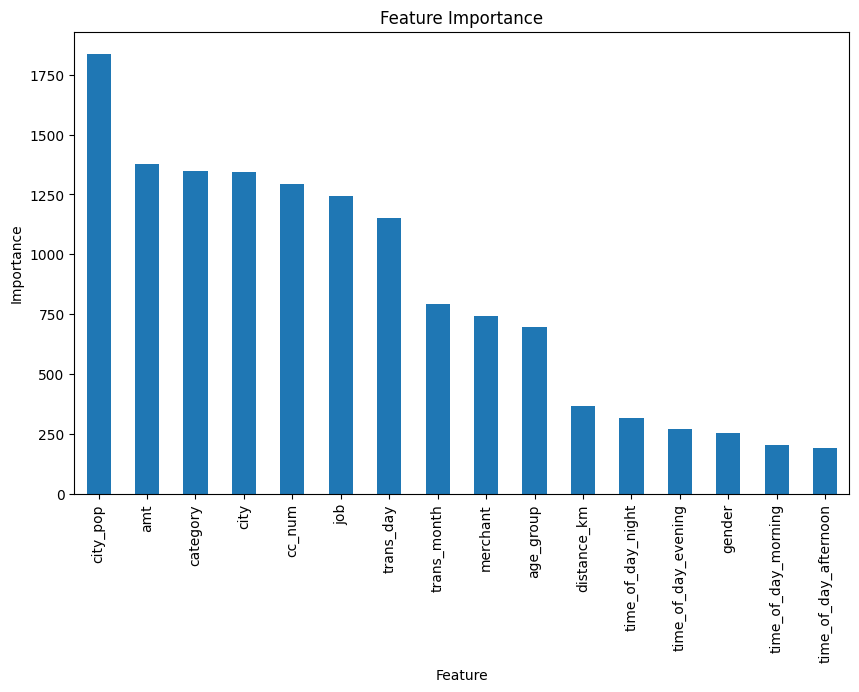

In [19]:
# feature importance 
import matplotlib.pyplot as plt
feature_importance = random_search.best_estimator_.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10,6))
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

/home/seven/Internship/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/seven/Internship/venv/lib/python3.12/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


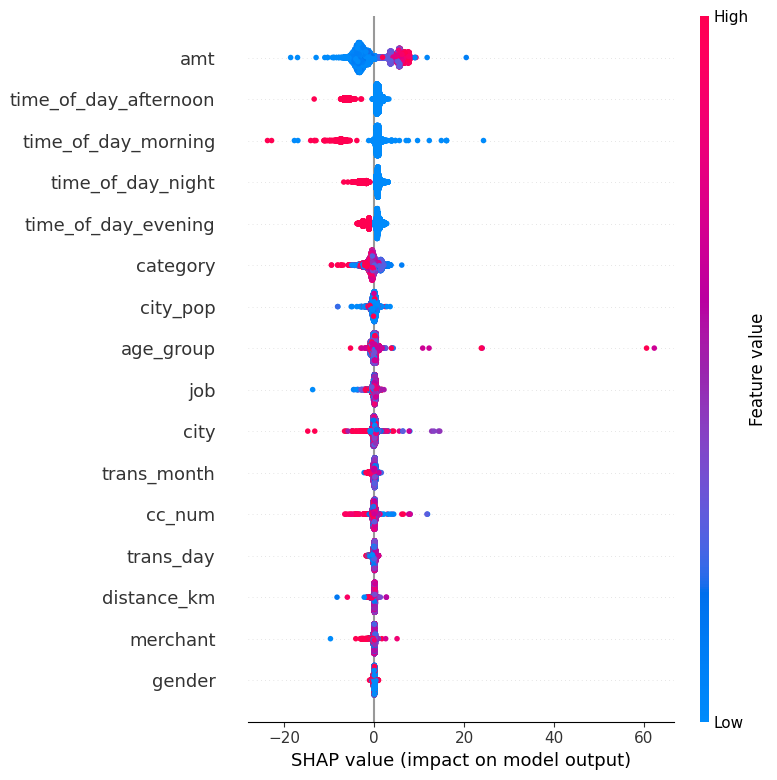

In [20]:
#using shap
import shap
explainer = shap.TreeExplainer(random_search.best_estimator_)
sample_X = X_train.sample(n = 10000, random_state = 42)

shap_values = explainer.shap_values(sample_X)
shap.summary_plot(shap_values, sample_X, show=False)


XGboost


In [21]:
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2577208 entries, 0 to 2577207
Data columns (total 16 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   cc_num                 int64  
 1   merchant               int64  
 2   category               int64  
 3   amt                    float64
 4   gender                 int64  
 5   city                   int64  
 6   city_pop               int64  
 7   job                    int64  
 8   trans_month            int32  
 9   trans_day              int32  
 10  time_of_day_afternoon  int64  
 11  time_of_day_evening    int64  
 12  time_of_day_morning    int64  
 13  time_of_day_night      int64  
 14  distance_km            float64
 15  age_group              int64  
dtypes: float64(2), int32(2), int64(12)
memory usage: 294.9 MB


In [22]:
#doing XG boost implementation
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
#reduce train and create another test set 
X_sample, X_sampletest, y_sample, y_sampletest = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)
from xgboost import XGBClassifier

In [23]:
experiment_description = "Credit Card Fraud Detection-Xgboost"
experiment_tags = {
    "model_type": "Xgboost",
    "dataset": "Credit Card Fraud",
    "model_version": "v1"
}


In [24]:
parameters_grid = {
    'n_estimators': [200,500, 1000],
    'max_depth': [4,6,8],
    'learning_rate': [0.05 ,0.1],
    'subsample': [0.7, 0.8],

}
xgboost_model = XGBClassifier(**parameters_grid)
random_search = RandomizedSearchCV(estimator=xgboost_model, param_distributions=parameters_grid, n_iter=20, cv=3, random_state=42, n_jobs=-1 , verbose=2)
random_search.fit(X_sample, y_sample )  
y_pred = random_search.predict(X_test)

xgbmodel = joblib.dump(random_search, 'xgboost_model.pkl')

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

metric = {
    "f1_score": f1,
    "precision": precision,
    "recall": recall}

with mlflow.start_run(client.get_experiment_by_name("/home/seven/Internship/Assignment credit card fraud detection (multi model)/XGBoost_Credit_Card_Fraud_Detection")) as run:
    mlflow.log_param("parameters_grid", parameters_grid)
    mlflow.log_metrics(metric)
    mlflow.log_dict(report, "classification_report.json")
    mlflow.xgboost.log_model(random_search.best_estimator_, "model")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.8; total time= 1.6min
[CV] END learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.8; total time= 1.6min
[CV] END learning_rate=0.05, max_depth=8, n_estimators=200, subsample=0.8; total time= 1.7min
[CV] END learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.7; total time= 2.5min
[CV] END learning_rate=0.1, max_depth=8, n_estimators=1000, subsample=0.8; total time= 7.5min
[CV] END learning_rate=0.1, max_depth=8, n_estimators=1000, subsample=0.8; total time= 7.6min
[CV] END learning_rate=0.1, max_depth=8, n_estimators=1000, subsample=0.8; total time= 7.6min
[CV] END learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.7; total time= 1.5min
[CV] END learning_rate=0.1, max_depth=8, n_estimators=200, subsample=0.7; total time= 1.5min
[CV] END learning_rate=0.1, max_depth=6, n_estimators=500, subsample=0.7; total time= 2.8min
[CV

Traceback (most recent call last):
  File "/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 367, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 465, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1635, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1628, in _read_helper
    result = read_yaml(root, file_name)
    

🏃 View run casual-lynx-846 at: http://127.0.0.1:8080/#/experiments/0/runs/773c18db439d4a2e942a703650705f7e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/0


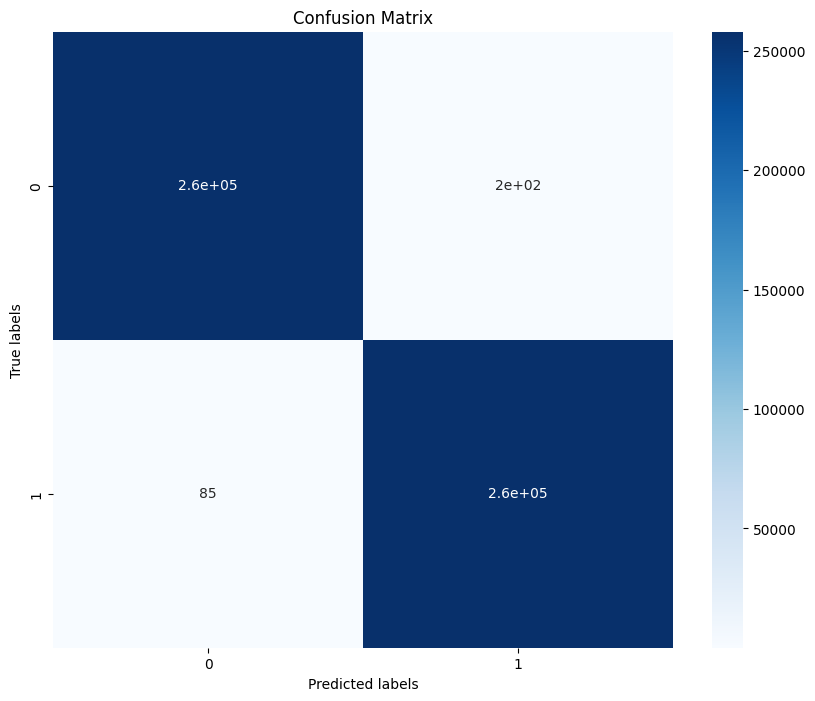

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap="Blues")

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [26]:
report = classification_report(y_test, y_pred, output_dict=True)
report

{'0': {'precision': 0.9996696604498059,
  'recall': 0.9992114330553279,
  'f1-score': 0.9994404942300967,
  'support': 257429.0},
 '1': {'precision': 0.9992135776020703,
  'recall': 0.9996705592353874,
  'f1-score': 0.9994420161815307,
  'support': 258013.0},
 'accuracy': 0.9994412562422155,
 'macro avg': {'precision': 0.9994416190259381,
  'recall': 0.9994409961453576,
  'f1-score': 0.9994412552058137,
  'support': 515442.0},
 'weighted avg': {'precision': 0.9994413606531405,
  'recall': 0.9994412562422155,
  'f1-score': 0.9994412560680055,
  'support': 515442.0}}

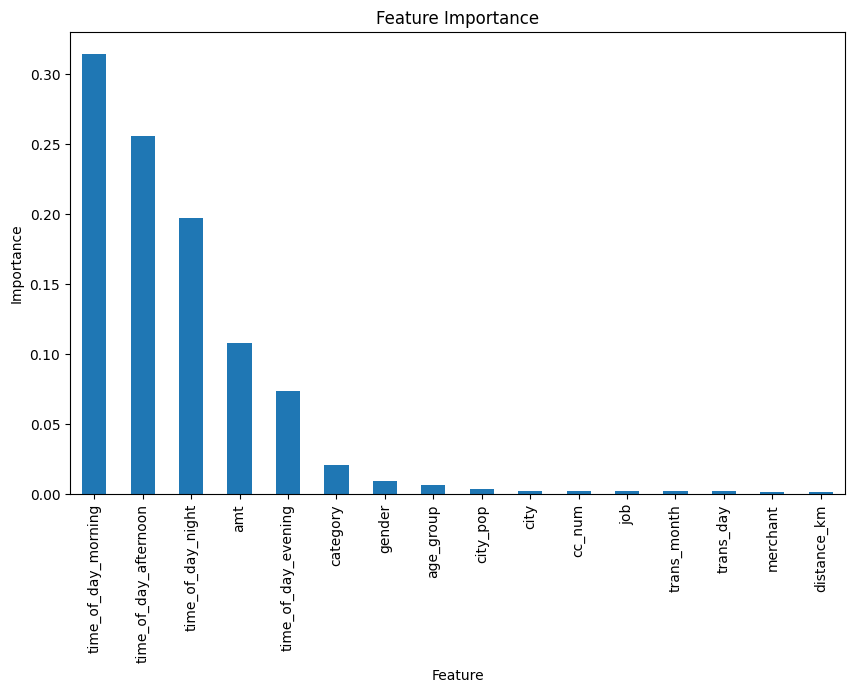

In [31]:
import matplotlib.pyplot as plt

# Access the best estimator (XGBClassifier) from RandomizedSearchCV
feature_importance = random_search.best_estimator_.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10,6))
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

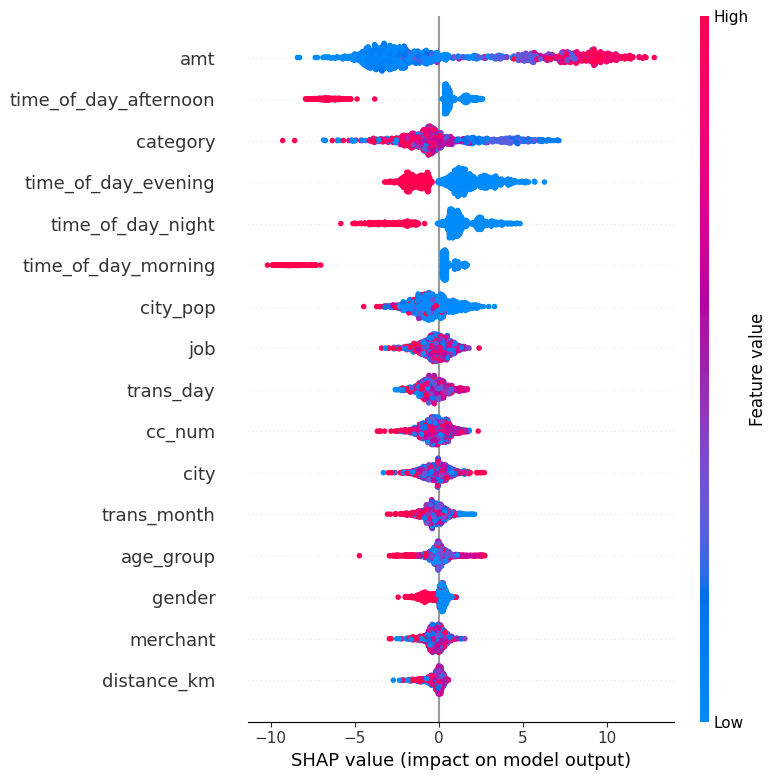

In [33]:
#using shap
import shap
explainer = shap.TreeExplainer(random_search.best_estimator_)
sample_X = X_train.sample(n = 1000, random_state = 42)

shap_values = explainer.shap_values(sample_X)
shap.summary_plot(shap_values, sample_X, show=False)

Random forest 

In [34]:
X_sample = X_resampled.sample(n = 500000, random_state = 42)
y_sample = y_resampled.loc[X_sample.index]
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)


In [35]:
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,   
    cv=2,       
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rf_random.fit(X_train, y_train)
rf_model= joblib.dump(rf_random, 'randomforest_model.pkl')
print("Best params:", rf_random.best_params_)



Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.1min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.2min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.2min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.2min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.6min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.6min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.1min
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.1

In [37]:
y_pred = rf_random.predict(X_test)

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)


metric = {
    "f1_score": f1,
    "precision": precision,
    "recall": recall
    }

with mlflow.start_run(client.get_experiment_by_name("/home/seven/Internship/Assignment credit card fraud detection (multi model)/Random Forest Model-credit_card Fraud_dectection1")) as run:
    mlflow.log_param("param_dist", param_dist)
    mlflow.log_metrics(metric)
    mlflow.log_dict(report, "classification_report.json")
    mlflow.sklearn.log_model(rf_random.best_estimator_, "model")

Traceback (most recent call last):
  File "/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 367, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 465, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1635, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seven/Internship/venv/lib/python3.12/site-packages/mlflow/store/tracking/file_store.py", line 1628, in _read_helper
    result = read_yaml(root, file_name)
    

🏃 View run nebulous-loon-356 at: http://127.0.0.1:8080/#/experiments/0/runs/8a5a3ea8483d4e78b590ffbc32b08d90
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/0


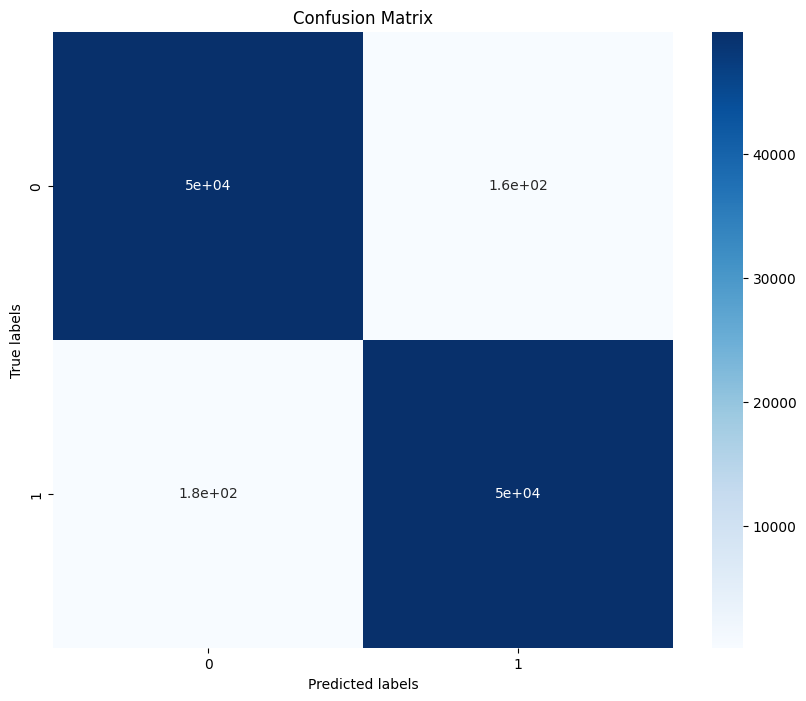

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap="Blues")

plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [39]:
report = classification_report(y_test, y_pred, output_dict=True)
report

{'0': {'precision': 0.9963061318211769,
  'recall': 0.9969032825205283,
  'f1-score': 0.9966046177199009,
  'support': 50053.0},
 '1': {'precision': 0.9968948454434361,
  'recall': 0.9962960738382686,
  'f1-score': 0.9965953697027958,
  'support': 49947.0},
 'accuracy': 0.9966,
 'macro avg': {'precision': 0.9966004886323065,
  'recall': 0.9965996781793984,
  'f1-score': 0.9965999937113483,
  'support': 100000.0},
 'weighted avg': {'precision': 0.9966001766140866,
  'recall': 0.9966,
  'f1-score': 0.9965999986127974,
  'support': 100000.0}}

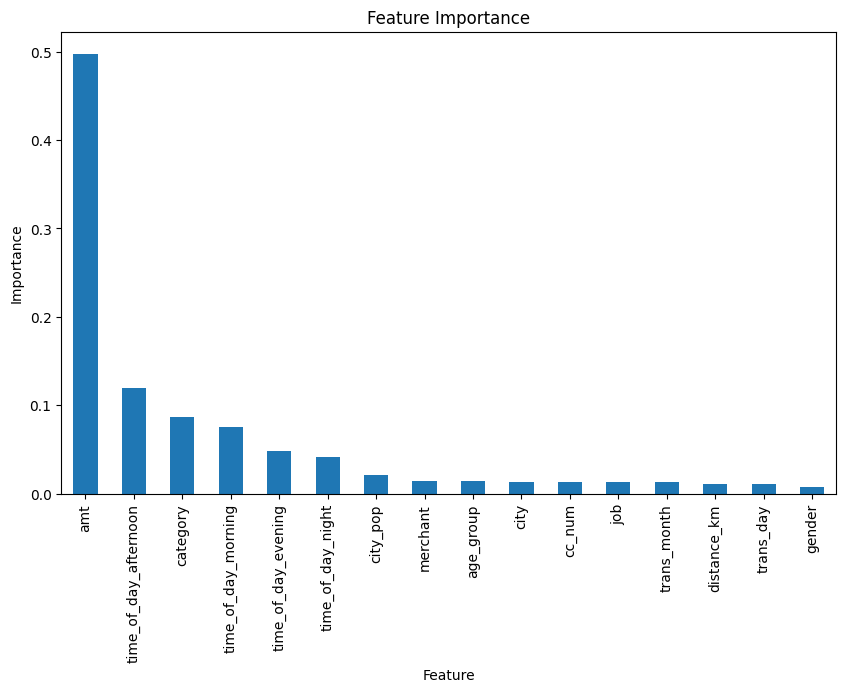

In [41]:
import matplotlib.pyplot as plt
feature_importance = rf_random.best_estimator_.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df.plot(kind='bar', x='Feature', y='Importance', legend=False, figsize=(10,6))
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [ ]:

import shap
explainer = shap.TreeExplainer(rf_random.best_estimator_)
sample_X = X_train.sample(n = 10000, random_state = 42)

shap_values = explainer.shap_values(sample_X)
shap.summary_plot(shap_values, sample_X, show=False)